<a href="https://colab.research.google.com/github/HKRcodes/Knowledge-Graph-Based-Hybrid-Extractive-Abstractive-Text-Summarization/blob/main/Knowledge_Graph_based_Hybrid_Extractive_Abstractive_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Knowledge Graph based Hybrid Extractive-Abstractive Text Summarization**

**Installing Libraries**

In [ ]:
!pip install PyPDF2 --q
!pip install transformers --q
!apt-get install -y poppler-utils --q
!pip install transformers networkx --q
!transformers-cli cache clear --q
# !pip install --upgrade pip
# !pip install spacy-transformers --q
# !python -m spacy download en_core_web_lg --q
# !python -m spacy download en_trf_bertbaseuncased_lg --q
# !pip install SentencePiece --q
# !pip install textract --q
# !pip install spacy --q
# !pip install sacremoses --q
# !pip install textacy --q
# !pip install spacy==3.0.0 --q
# !python -m spacy download en_trf_bertbaseuncased_lg --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00
E: Command line option --q is not understood in combination with the other options
2023-06-12 08:17:45.951280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: transformers-cli <command> [<args>]
Transformers CLI tool: error: argument {convert,download,env,run,serve,login,whoami,logout,repo,add-new-model,add-new-model-like,lfs-enable-largefiles,lfs-multipart-upload,pt-to-tf}: invalid choice: 'cache' (choose from 'convert', 'download', 'env', 'run', 'serve', 'login', 'whoami', 'logout', 'repo', 'add-new-model', 'add-new-model-like', 'lfs-enab

**Importing required libraries**

In [ ]:
import PyPDF2
from io import StringIO
import os
import requests
from bs4 import BeautifulSoup
import torch
from transformers import LongformerTokenizer, LongformerModel, pipeline
import nltk
import re
import networkx as nx
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
import numpy as np


nltk.download('punkt')

# import spacy
# import networkx as nx
# import textract
# from spacy import displacy
# import textacy
# import sacremoses as sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# The following output must be cuda to ensure that the GPU is used

cuda:0


**Sentence segmentation function**

In [ ]:
def split_into_sentences(paragraph):
    sentences = nltk.sent_tokenize(paragraph)
    return sentences

**Set up the Abstractive summarization model**

In [ ]:
summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum", device='cuda:0')
# summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")

**Set up the Extractive summarization model**

In [ ]:
# Initialize Longformer tokenizer and model
longformer_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
longformer_model = LongformerModel.from_pretrained('allenai/longformer-base-4096')

# Move the model to the GPU
longformer_model.to(device)
print("Loader longformer to device")

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loader longformer to device


**Function to count words in a sentence**

In [ ]:
def count_words(sentence):
    return len(re.findall(r"\w+", sentence))

In [ ]:
!pip install pdfminer.six --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.9 MB/s eta 0:00:00


**Input reading functions**

In [ ]:
# Function to read and extract text from a PDF document
def read_pdf(file_path):
    if not os.path.isfile(file_path) or not file_path.endswith('.pdf'):
        raise ValueError('Invalid file path or file format. Please provide a valid PDF file.')
    from pdfminer.high_level import extract_text
    text = extract_text(file_path)
    return text


# Function to read and extract text from a text document
def read_text(file_path):
    if not os.path.isfile(file_path) or not file_path.endswith('.txt'):
        raise ValueError('Invalid file path or file format. Please provide a valid text file.')
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        return text

# Function to read and extract text from a website URL
def read_url(url):
    try:
        response = requests.get(url)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')
        main_content = soup.find(class_='main-content')
        text = main_content.get_text()
        return text
    except:
        raise ValueError('Invalid URL or unable to extract text from URL. Please provide a valid website URL.')

**Knowledge-Graph based Extractive summarization functions**

In [ ]:
def sentence_embedding(sentence):
    # Tokenize the sentence
    tokens = longformer_tokenizer.tokenize(sentence)

    # Convert tokens to input IDs
    input_ids = longformer_tokenizer.encode(tokens, add_special_tokens=True)

    # Convert input IDs to a tensor
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

    # Get the last hidden states from the Longformer model
    with torch.no_grad():
        outputs = longformer_model(input_ids=input_ids)
        last_hidden_states = outputs.last_hidden_state

    # Average pooling to get the sentence embedding
    sentence_embedding = torch.mean(last_hidden_states, dim=1).squeeze(0).cpu().numpy()

    return sentence_embedding
'''

****** You can use this if you dont want the graph visualisation. ******

def create_knowledge_graph(text):
    # Split the text into sentences
    sentences = sent_tokenize(text)
    # Create an empty graph
    graph = nx.Graph()
    # Add sentences as nodes to the graph
    graph.add_nodes_from(range(len(sentences)))

    embeddings = []
    for sentence in sentences:
        embeddings.append(sentence_embedding(sentence))
    embeddings = np.vstack(embeddings)

    similarity_matrix = cosine_similarity(embeddings, embeddings)

    # Calculate sentence similarity and add edges to the graph
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            similarity = similarity_matrix[i, j]
            graph.add_edge(i, j, weight=similarity)

    return graph
'''
import matplotlib.pyplot as plt

def create_knowledge_graph(text):
    # Split the text into sentences
    sentences = sent_tokenize(text)
    # Create an empty graph
    graph = nx.Graph()
    # Add sentences as nodes to the graph
    graph.add_nodes_from(range(len(sentences)))

    embeddings = []
    for sentence in sentences:
        embeddings.append(sentence_embedding(sentence))
    embeddings = np.vstack(embeddings)

    similarity_matrix = cosine_similarity(embeddings, embeddings)

    # Calculate sentence similarity and add edges to the graph
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            similarity = similarity_matrix[i, j]
            graph.add_edge(i, j, weight=similarity)

    # Visualize the knowledge graph
    pos = nx.spring_layout(graph)  # Layout for node positioning
    weights = nx.get_edge_attributes(graph, 'weight')  # Edge weights

    plt.figure(figsize=(10, 8))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=10, width=1.5, alpha=0.8)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=weights)
    plt.title("Knowledge Graph Visualization")
    plt.show()

    return graph


def extractive_summarization_with_knowledge_graph(input_text):
    sentences = sent_tokenize(input_text)
    # Create the knowledge graph
    graph = create_knowledge_graph(input_text)
    # Apply TextRank algorithm to rank the sentences based on graph centrality
    sentence_scores = nx.pagerank(graph, weight='weight')
    # Sort the sentences by score in descending order
    ranked_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)
    # Select the top sentences as the summary
    summary_sentences = ranked_sentences[:10]  # Adjust the number of sentences for the summary
    # Sort the summary sentences based on their original order
    summary_sentences.sort()
    # Construct the final summary
    summary = ' '.join([sentences[idx] for idx in summary_sentences])
    return summary

**Model Training**

In [ ]:
'''

***** This code segment is commented and not used in program because of insufficient computational resource. ******
***** Initially i included this part in the code and when i ran it in colab, the RAM usage became exhausted very quickly even after setting GPU to Tesla T4 and colab having 12 GB RAM. ******
***** You can try using this code segment if you have the computational requirements. When you use this, please use the Commented abstractive_summarization function body given below. ******


import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW  # Import the optimizer

class CNNDailyMailDataset(Dataset):
    def __init__(self, data_path):
        self.data = self.load_dataset(data_path)

    def load_dataset(self, data_path):
        data = []
        dataset = pd.read_csv(data_path)
        dataset = dataset[:10]
        dataset = dataset.drop('id', axis=1)
        for idx, row in dataset.iterrows():
            text = row['article']
            summary = row['highlights']
            data.append((text, summary))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, summary = self.data[idx]
        return text, summary

data_path = "/content/summarizer_dataset.csv"

dataset = CNNDailyMailDataset(data_path)

tokenizer = BartTokenizer.from_pretrained("philschmid/bart-large-cnn-samsum")
model = BartForConditionalGeneration.from_pretrained("philschmid/bart-large-cnn-samsum")

optimizer = AdamW(model.parameters(), lr=1e-5)  # Initialize the optimizer

for epoch in range(10):
    batch_size = 10
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    max_input_length = 1024
    max_summary_length = 500

    for batch in dataloader:
        batch = list(zip(*batch))  # Convert the batch to a list
        input_texts = batch[0]
        reference_summaries = batch[1]

        input_encodings = tokenizer.batch_encode_plus(
            input_texts,
            padding='longest',
            truncation=True,
            max_length=max_input_length,
            return_tensors='pt'
        )
        input_ids = input_encodings['input_ids']
        attention_mask = input_encodings['attention_mask']

        decoder_encodings = tokenizer.batch_encode_plus(
            reference_summaries,
            padding='longest',
            truncation=True,
            max_length=max_summary_length,
            return_tensors='pt'
        )
        decoder_ids = decoder_encodings['input_ids']
        decoder_attention_mask = decoder_encodings['attention_mask']

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=decoder_ids
        )

        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Save the trained model
model.save_pretrained("/content/trained_model")
'''

'\nimport pandas as pd\nfrom transformers import BartTokenizer, BartForConditionalGeneration\nfrom torch.utils.data import Dataset, DataLoader\nfrom transformers import AdamW  # Import the optimizer\n\nclass CNNDailyMailDataset(Dataset):\n    def __init__(self, data_path):\n        self.data = self.load_dataset(data_path)\n\n    def load_dataset(self, data_path):\n        data = []\n        dataset = pd.read_csv(data_path)\n        dataset = dataset[:10]\n        dataset = dataset.drop(\'id\', axis=1)\n        for idx, row in dataset.iterrows():\n            text = row[\'article\']\n            summary = row[\'highlights\']\n            data.append((text, summary))\n        return data\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        text, summary = self.data[idx]\n        return text, summary\n\ndata_path = "/content/summarizer_dataset.csv"\n\ndataset = CNNDailyMailDataset(data_path)\n\ntokenizer = BartTokenizer.from_pretrained("phil

**Abstractive summarization function**

In [ ]:
def abstractive_summarization(input_text):
    num_of_sentence_per_chunk = 10
    sentences = split_into_sentences(input_text)
    sentence_chunks = []
    summarised_output = ''
    ct = 0
    while ct <= len(sentences):
        chunk = sentences[ct: ct+num_of_sentence_per_chunk]
        chunk = ' '.join(chunk)
        if len(chunk) > 700:
            sentence_chunks.append(chunk)
        ct += num_of_sentence_per_chunk
    progress = 0
    for chunk in sentence_chunks:
        data = summarizer(chunk, min_length=150, max_length=200)[0]['summary_text']
        summarised_output += data
        progress += 1
    return summarised_output

'''
# When the model is fine tuned with a dataset; the following code need to be used for abstractive summarization


# Load the trained model in the abstractive_summarization function

from transformers import BartTokenizer, BartForConditionalGeneration

def abstractive_summarization(input_text):
    num_of_sentence_per_chunk = 10
    sentences = split_into_sentences(input_text)
    sentence_chunks = []
    summarised_output = ''
    ct = 0
    while ct <= len(sentences):
        chunk = sentences[ct: ct+num_of_sentence_per_chunk]
        chunk = ' '.join(chunk)
        if len(chunk) > 700:
            sentence_chunks.append(chunk)
        ct += num_of_sentence_per_chunk
    progress = 0

    # Load the trained model
    loaded_model = BartForConditionalGeneration.from_pretrained("/content/trained_model")
    tokenizer = BartTokenizer.from_pretrained("philschmid/bart-large-cnn-samsum")

    for chunk in sentence_chunks:
        inputs = tokenizer.encode(chunk, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = loaded_model.generate(inputs, num_beams=4, min_length=150, max_length=200, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summarised_output += summary + ' '
        progress += 1
    return summarised_output
'''

'\n# Load the trained model in the abstractive_summarization function\n\nfrom transformers import BartTokenizer, BartForConditionalGeneration\n\ndef abstractive_summarization(input_text):\n    num_of_sentence_per_chunk = 10\n    sentences = split_into_sentences(input_text)\n    sentence_chunks = []\n    summarised_output = \'\'\n    ct = 0\n    while ct <= len(sentences):\n        chunk = sentences[ct: ct+num_of_sentence_per_chunk]\n        chunk = \' \'.join(chunk)\n        if len(chunk) > 700:\n            sentence_chunks.append(chunk)\n        ct += num_of_sentence_per_chunk\n    progress = 0\n    \n    # Load the trained model\n    loaded_model = BartForConditionalGeneration.from_pretrained("/content/trained_model")\n    tokenizer = BartTokenizer.from_pretrained("philschmid/bart-large-cnn-samsum")\n    \n    for chunk in sentence_chunks:\n        inputs = tokenizer.encode(chunk, return_tensors=\'pt\', max_length=1024, truncation=True)\n        summary_ids = loaded_model.generate(in

**H-E-A-T summarization function**

In [ ]:
def summarize_file(file_path_or_url):
    # Check if the input is a file path or a website URL
    if os.path.isfile(file_path_or_url):
        file_path = file_path_or_url
        # Read and extract text from the input file
        if file_path.endswith('.pdf'):
            text = read_pdf(file_path)
        elif file_path.endswith('.txt'):
            text = read_text(file_path)
        else:
            raise ValueError('Invalid file format. Please provide a valid PDF or text file.')
    else:
        # Read and extract text from the website URL
        text = read_url(file_path_or_url)

    print('TEXT: -------------------\n',text,'\n-----------------------------')

    # Perform extractive summarization
    extractive_summary = extractive_summarization_with_knowledge_graph(text)

    # Perform abstractive summarization
    abstractive_summary = abstractive_summarization(text)

    return abstractive_summary, extractive_summary

**Main body**

TEXT: -------------------
 EARTH EATS

We try to bridge the fact that 40% of food produced is wasted while approximately 14.8% of the
people remain undernourished. We will provide an interface via an app for people to buy and
sell excess food from large functions or events thus reducing the practice of using food after
long refrigeration and financial stress on food manufacturers by reducing storage cost and We
hire employees on independent contracts whose wages are based on the number of deliveries
and thus act as a part time job opportunity.

Vendors can sell excess Fruits and vegetables at reduced cost before it spoils. This reduces
stress on these vendors preventing excess use of pesticides and ensures minimum profit.

This app helps producers trade surplus food at functions at 50-60% cost, preventing food
wastage or free distribution giving enough returns. A worker depending on daily wage to win
bread when falls sick and cannot go to work can avail food from a base price of 40% vi

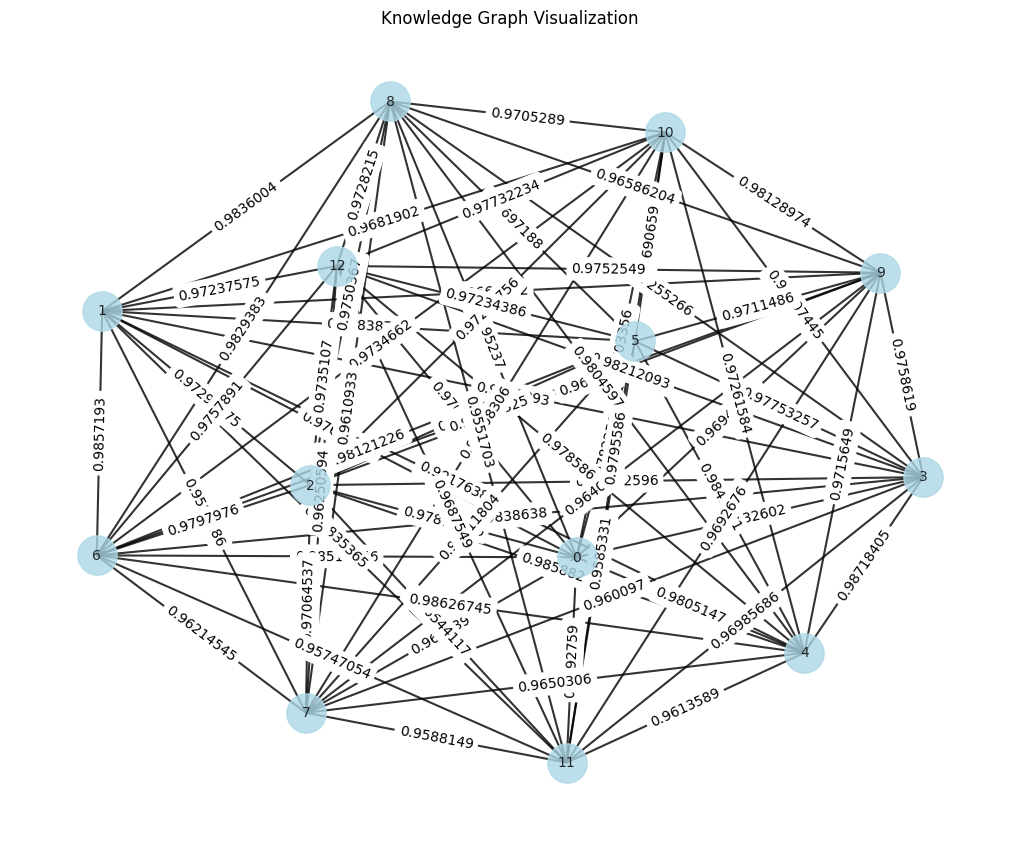

Extractive Summary:
EARTH EATS

We try to bridge the fact that 40% of food produced is wasted while approximately 14.8% of the
people remain undernourished. We will provide an interface via an app for people to buy and
sell excess food from large functions or events thus reducing the practice of using food after
long refrigeration and financial stress on food manufacturers by reducing storage cost and We
hire employees on independent contracts whose wages are based on the number of deliveries
and thus act as a part time job opportunity. Vendors can sell excess Fruits and vegetables at reduced cost before it spoils. This reduces
stress on these vendors preventing excess use of pesticides and ensures minimum profit. This app helps producers trade surplus food at functions at 50-60% cost, preventing food
wastage or free distribution giving enough returns. A worker depending on daily wage to win
bread when falls sick and cannot go to work can avail food from a base price of 40% via this
pl

In [ ]:
# file_path = 'https://www.nature.com/articles/d41586-023-01714-6'
file_path = '/content/EARTH EATS (1).pdf'
abstractive_summary, extractive_summary = summarize_file(file_path)
print("Extractive Summary:")
print(extractive_summary)
print("\nAbstractive Summary:")
print(abstractive_summary)
print("\nThe hybrid method Summary is:")
hybrid_summary = abstractive_summarization(extractive_summary)
print(hybrid_summary)

**size comparison**

In [ ]:
try:
    # Try opening the file as a text file
    with open(file_path, 'r', encoding='utf-8') as file:
        in_text = file.read()
except (FileNotFoundError,UnicodeDecodeError):
    # If a UnicodeDecodeError occurs, it means the file is not a text file
    # In that case, read the PDF file separately
    if file_path.endswith('.pdf'):
        in_text = read_pdf(file_path)
    else:
        # If it's not a PDF file, assume it's a URL and attempt to read from it
        try:
            in_text = read_url(file_path)
        except ValueError:
            raise ValueError('Invalid URL or unable to extract text from URL. Please provide a valid website URL.')

print(f"Words in Input text: {count_words(in_text)}")
print(f"Words in Extractive summary: {count_words(extractive_summary)}")
print(f"Words in Abstractive summary: {count_words(abstractive_summary)}")
print(f"Words in Hybrid summary: {count_words(hybrid_summary)}")

Words in Input text: 302
Words in Extractive summary: 268
Words in Abstractive summary: 128
Words in Hybrid summary: 121


# **Evaluating the summarization performance**

In [ ]:
!pip install --upgrade git+https://github.com/pltrdy/rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pltrdy/rouge to /tmp/pip-req-build-fbn1zekw
  Running command git clone --filter=blob:none --quiet https://github.com/pltrdy/rouge /tmp/pip-req-build-fbn1zekw
  Resolved https://github.com/pltrdy/rouge to commit c1b90a78c303b5d5956b1c1f2dac19cdd553d9b9
  Preparing metadata (setup.py) ... done
  Created wheel for rouge: filename=rouge-1.0.1-py3-none-any.whl size=13716 sha256=1857fe26f4274fa56405006d88f3480d2e13ed97eed73b0d53d112b48caf7528
  Stored in directory: /tmp/pip-ephem-wheel-cache-c50i0arq/wheels/e0/97/4e/9c3e272e6348c051ba3126c0a67a1529451bcb8c3b7b2a4365
Successfully built rouge


**Rouge score comparison for the summaries**

In [ ]:
from rouge import Rouge

def evaluate_summary(summary, reference):
    rouge = Rouge()
    scores = rouge.get_scores(summary, reference)
    return scores

# Evaluate the performance of the summarization system using a reference summary

# Assuming reference_summary is the ground truth or a high-quality summary
# reference_summary = "The input text comprehensively explores a wide range of aspects related to the topic, delving into intricate details, providing insightful analysis, and presenting multiple perspectives. The summary showcases a meticulous selection of key points, crucial information, and critical findings, ensuring a comprehensive and thorough overview of the main ideas conveyed in the text. It effectively captures the essence of the topic, offering a nuanced understanding and facilitating a deeper exploration of the subject matter." # This is the reference summary

reference_summary = "EARTH EATS is an app-based solution aimed at reducing food wastage and malnourishment. It connects producers and consumers, allowing the sale of excess food at discounted prices. By minimizing waste, providing affordable food, and creating employment opportunities, EARTH EATS addresses the global problem of food wastage. With a comprehensive approach and unique features, such as offering cooked food and local food information, EARTH EATS sets itself apart from competitors. The platform's potential for profitability and growth is significant."

#reference_summary = "EARTH EATS tackles the global problem of food wastage and malnourishment through an app that connects producers and consumers. By selling excess food at discounted prices, reducing reliance on refrigeration, and creating employment opportunities, EARTH EATS aims to minimize waste, provide affordable food, and promote a greener Earth. With a comprehensive approach that addresses multiple aspects, EARTH EATS stands out among competitors and has the potential for significant growth and profitability."


# Evaluate the quality of the generated summary using evaluation metrics
# We can use evaluation metrics such as ROUGE or BLEU to compare the generated summary with the reference summary.
# Here ROUGE metric is used
# Perform the necessary evaluation and print the evaluation results

print("Summary Evaluation Results:")
print("Abstractive Summary:")
print(evaluate_summary(abstractive_summary, reference_summary))
print("Extractive Summary:")
print(evaluate_summary(extractive_summary, reference_summary))
print("Hybrid Summary:")
print(evaluate_summary(hybrid_summary, reference_summary))


Summary Evaluation Results:
Abstractive Summary:
[{'rouge-1': {'r': 0.2833333333333333, 'p': 0.18085106382978725, 'f': 0.22077921602293823}, 'rouge-2': {'r': 0.06756756756756757, 'p': 0.04132231404958678, 'f': 0.051282046572518517}, 'rouge-l': {'r': 0.26666666666666666, 'p': 0.1702127659574468, 'f': 0.20779220303592522}}]
Extractive Summary:
[{'rouge-1': {'r': 0.4166666666666667, 'p': 0.14285714285714285, 'f': 0.2127659536441829}, 'rouge-2': {'r': 0.10810810810810811, 'p': 0.031007751937984496, 'f': 0.04819276762011928}, 'rouge-l': {'r': 0.36666666666666664, 'p': 0.12571428571428572, 'f': 0.18723403875056593}}]
Hybrid Summary:
[{'rouge-1': {'r': 0.3333333333333333, 'p': 0.23529411764705882, 'f': 0.2758620641141499}, 'rouge-2': {'r': 0.10810810810810811, 'p': 0.06896551724137931, 'f': 0.08421052156011108}, 'rouge-l': {'r': 0.31666666666666665, 'p': 0.2235294117647059, 'f': 0.26206896066587404}}]


**F1 score comparison of summaries**

In [ ]:
from rouge import Rouge

def evaluate_summary(summary, reference):
    rouge = Rouge()
    scores = rouge.get_scores(summary, reference)
    return scores  # Return the first score in the list


def calculate_average_f_scores(scores):
    average_score = 0
    total = 0
    for metric in scores[0]:
        total += scores[0][metric]['f']
        #total = sum(score[metric] for score in scores)
    average_score = total / 3
    return average_score

# Example usage

# reference_summary = "The input text comprehensively explores a wide range of aspects related to the topic, delving into intricate details, providing insightful analysis, and presenting multiple perspectives. The summary showcases a meticulous selection of key points, crucial information, and critical findings, ensuring a comprehensive and thorough overview of the main ideas conveyed in the text. It effectively captures the essence of the topic, offering a nuanced understanding and facilitating a deeper exploration of the subject matter."

reference_summary = "EARTH EATS is an app-based solution aimed at reducing food wastage and malnourishment. It connects producers and consumers, allowing the sale of excess food at discounted prices. By minimizing waste, providing affordable food, and creating employment opportunities, EARTH EATS addresses the global problem of food wastage. With a comprehensive approach and unique features, such as offering cooked food and local food information, EARTH EATS sets itself apart from competitors. The platform's potential for profitability and growth is significant."

#reference_summary = "EARTH EATS tackles the global problem of food wastage and malnourishment through an app that connects producers and consumers. By selling excess food at discounted prices, reducing reliance on refrigeration, and creating employment opportunities, EARTH EATS aims to minimize waste, provide affordable food, and promote a greener Earth. With a comprehensive approach that addresses multiple aspects, EARTH EATS stands out among competitors and has the potential for significant growth and profitability."


# Evaluate summaries
#reference_scores = evaluate_summary(reference_summary, reference_summary)
abstractive_scores = evaluate_summary(abstractive_summary, reference_summary)
extractive_scores = evaluate_summary(extractive_summary, reference_summary)
hybrid_scores = evaluate_summary(hybrid_summary, reference_summary)


# Calculate average scores
#average_reference_score = calculate_average_f_scores(reference_scores)
average_abstractive_score = calculate_average_f_scores(abstractive_scores)
average_extractive_score = calculate_average_f_scores(extractive_scores)
average_hybrid_score = calculate_average_f_scores(hybrid_scores)

# Print average scores for comparison
print("********** Summarization Performance **********\n")
# print("Reference Summary:")
# print(average_reference_score)
print("\nAbstractive Summary:")
print(average_abstractive_score)
print("\nExtractive Summary:")
print(average_extractive_score)
print("\nHybrid Summary:")
print(average_hybrid_score)

# Compare average scores and determine the better summary
best_summary = max(average_abstractive_score, average_extractive_score, average_hybrid_score)
if best_summary == average_abstractive_score:
    print("\nThe abstractive summary is better.")
elif best_summary == average_extractive_score:
    print("\nThe extractive summary is better.")
else:
    print("\nThe hybrid summary is better.")
print('\n')

********** Summarization Performance **********


Abstractive Summary:
0.15995115521046066

Extractive Summary:
0.1493975866716227

Hybrid Summary:
0.20738051544671166

The hybrid summary is better.




In [ ]:
def evaluate_summary(summary, reference):
    rouge = Rouge()
    scores = rouge.get_scores(summary, reference)
    f1_scores = [score['rouge-l']['f'] for score in scores]
    return f1_scores[0]



# Example usage
# reference_summary = "EARTH EATS tackles the global problem of food wastage and malnourishment through an app that connects producers and consumers. By selling excess food at discounted prices, reducing reliance on refrigeration, and creating employment opportunities, EARTH EATS aims to minimize waste, provide affordable food, and promote a greener Earth. With a comprehensive approach that addresses multiple aspects, EARTH EATS stands out among competitors and has the potential for significant growth and profitability."
reference_summary = "EARTH EATS is an app-based solution aimed at reducing food wastage and malnourishment. It connects producers and consumers, allowing the sale of excess food at discounted prices. By minimizing waste, providing affordable food, and creating employment opportunities, EARTH EATS addresses the global problem of food wastage. With a comprehensive approach and unique features, such as offering cooked food and local food information, EARTH EATS sets itself apart from competitors. The platform's potential for profitability and growth is significant."



# Evaluate summaries
abstractive_score = evaluate_summary(abstractive_summary, reference_summary)
extractive_score = evaluate_summary(extractive_summary, reference_summary)
hybrid_score = evaluate_summary(hybrid_summary, reference_summary)


# Display average scores
print("********** Summarization Performance **********\n")
print("\nAbstractive Summary Average Score:")
print(abstractive_score)
print("\nExtractive Summary Average Score:")
print(extractive_score)
print("\nHybrid Summary Average Score:")
print(hybrid_score)


********** Summarization Performance **********


Abstractive Summary Average Score:
0.20779220303592522

Extractive Summary Average Score:
0.18723403875056593

Hybrid Summary Average Score:
0.26206896066587404
